In [1]:
import numpy as np
import cv2
from show_image import *
from datascience import *
import math
%matplotlib inline

---

- ## 어파인 변환
    - ### 입력 영상의 좌표3개, 목적 영상의 좌표 3개를 지정하여 $ x \rightarrow x' $ 변환
        - #### cv2.getAffineTransform(src, dst)
        - #### cv2.warpAffine(src, affine_matrix, size, flags)
            - #### size: (width, height) 형태의 반환 영상의 크기
            - #### flags: 보간 방법 (cv2.INTER_NEAREST, cv2.INTER_LINEAR, ...)

<br>

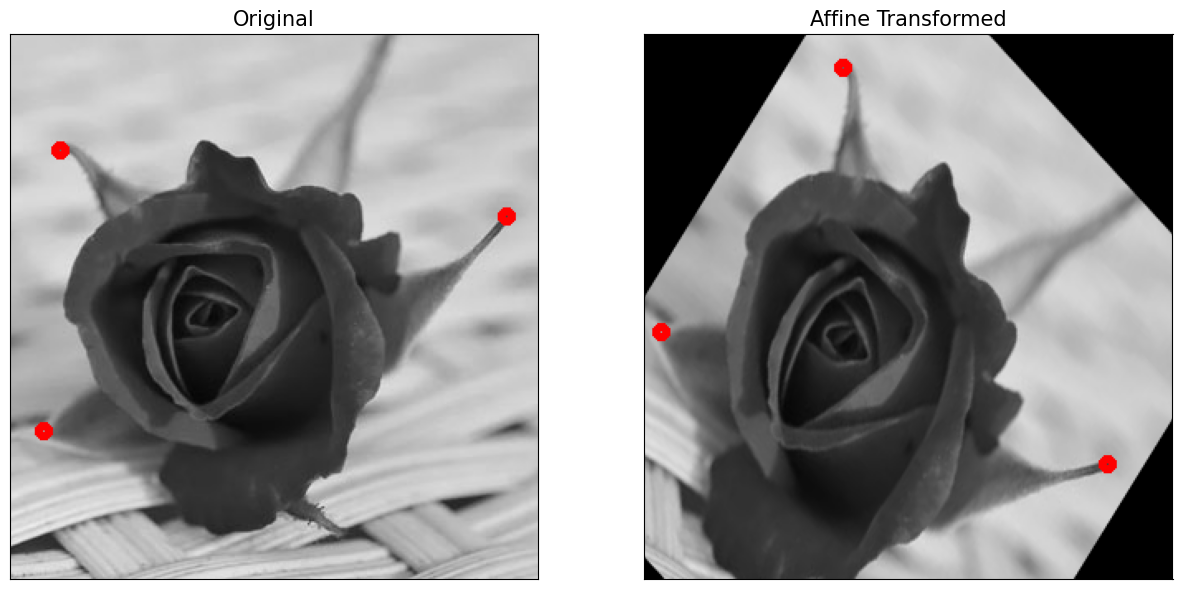

In [73]:
image = cv2.imread("./images/chap08/affine.jpg", cv2.IMREAD_GRAYSCALE)

image_size = image.shape[::-1] # (width, height) 형태의 이미지 크기

pt_before = np.array([(30, 70), (20, 240), (300, 110)], dtype="float32") # 입력 영상 좌표 3개
pt_after = np.array([(120, 20), (10, 180), (280, 260)], dtype="float32") # 목적 영상의 좌표 3개

affine_matrix = cv2.getAffineTransform(pt_before, pt_after)
affine_transformed = cv2.warpAffine(image, affine_matrix, image_size, cv2.INTER_LINEAR)

checked_original_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) # GrayScale 영상의 채널을 BGR로 변경
checked_transformed_image = cv2.cvtColor(affine_transformed, cv2.COLOR_GRAY2BGR)
for i in range(3):
    x, y = list(map(int, pt_before[i]))
    cv2.circle(checked_original_image, (x, y), 3, (0, 0, 255), 3, -1) # 원본 영상에 세 점 표시

    x_prime, y_prime = list(map(int, pt_after[i]))
    cv2.circle(checked_transformed_image, (x_prime, y_prime), 3, (0, 0, 255), 3, -1) # 변환된 영상에 세 점 표시

show_images({"Original": checked_original_image, "Affine Transformed": checked_transformed_image}, 15)

<br>

- ### 사용자 함수로 어파인 행렬 직접 구현하기
    - ### 어파인 변환 행렬
        - ### 회전 * 크기 변경 * 평행 이동

        <br>
        
        - ### $\begin{pmatrix}
        cos\theta & sin\theta & 0\\
        -sin\theta & cos\theta & 0 \\
        0 & 0 & 1 \\
        \end{pmatrix}$ $\cdot$ $\begin{pmatrix}
        \alpha & 0 & 0 \\
        0 & \beta & 0 \\
        0 & 0 & 1 \\
        \end{pmatrix}$ $\cdot$ $\begin{pmatrix}
        1 & 0 & t_x \\
        0 & 1 & t_y \\
        0 & 0 & 1 \\
        \end{pmatrix}$

    <br>
    
    - ### 과정
        - #### 1. Matrix = 영상의 중심을 원점으로 평행이동하는 행렬
        - #### 2. Matirx = 지정한 $f_x$, $f_y$ 만큼 크기 변경하는 행렬 $\cdot$ Matrix
        - #### 3. Matrix = 지정한 $t_x$, $t_y$ 만큼 평행이동하는 행렬 $\cdot$ Matrix 
        - #### 4. Matrix = 회전 행렬 $\cdot$ Matrix
        - #### 5. Matrix = 원점에서 다시 영상의 중심으로 평행이동하는 행렬 $\cdot$ Matrix

<br>

영상의 중심을 원점으로 평행이동하는 행렬: 
[[   1.    0. -160.]
 [   0.    1. -165.]
 [   0.    0.    1.]]
(0.5, 0.5)만큼 크기 변경하는 행렬: 
[[ 0.5  0.   0. ]
 [ 0.   0.5  0. ]
 [ 0.   0.   1. ]]
((50, 50))만큼 평행 이동하는 행렬: 
[[  1.   0.  50.]
 [  0.   1.  50.]
 [  0.   0.   1.]]
30만큼 회전하는 행렬: 
[[ 0.86615809  0.4997701   0.        ]
 [-0.4997701   0.86615809  0.        ]
 [ 0.          0.          1.        ]]
원점에서 영상의 중심으로 평행이동하는 행렬: 
[[   1.    0.  160.]
 [   0.    1.  165.]
 [   0.    0.    1.]]
Affine Matrix: 
[[   0.43307905    0.24988505  117.77272883]
 [  -0.24988505    0.43307905  151.84296501]]


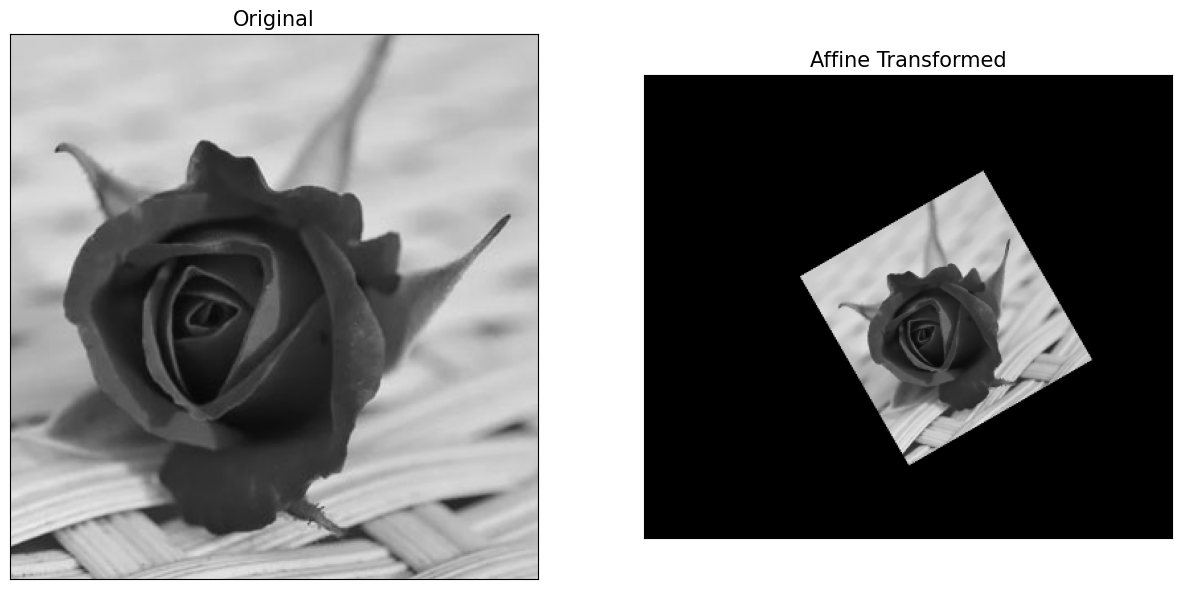

In [72]:
def get_affine_matrix(center, degree, fx=1, fy=1, translate=(0, 0)):
    move_to_zero = np.eye(3, 3)
    move_to_zero[:2, 2] = -1 * np.array(center).reshape(1, 2)
    print("영상의 중심을 원점으로 평행이동하는 행렬: ")
    print(move_to_zero)
    matrix = move_to_zero # 행렬 초기화

    scale = np.eye(3, 3)
    scale[0][0] = fx
    scale[1][1] = fy
    print("({0}, {1})만큼 크기 변경하는 행렬: ".format(fx, fy))
    print(scale)
    matrix = scale.dot(matrix) # 행렬 곱

    move_to_translate = np.eye(3, 3)
    move_to_translate[:2, 2] = np.array(translate).reshape(1, 2)
    print("({})만큼 평행 이동하는 행렬: ".format(translate))
    print(move_to_translate)
    matrix = move_to_translate.dot(matrix) # 행렬 곱

    rad = (degree / 180) * 3.14
    cos, sin = np.cos(rad), np.sin(rad)
    rotate = np.eye(3, 3)
    rotate[:2, :2] = [
        [cos, sin],
        [-sin, cos]
    ]
    print("{0}만큼 회전하는 행렬: ".format(degree))
    print(rotate)
    matrix = rotate.dot(matrix) # 행렬 곱

    move_to_center = np.eye(3, 3)
    move_to_center[:2, 2] = np.array(center).reshape(1, 2)
    print("원점에서 영상의 중심으로 평행이동하는 행렬: ")
    print(move_to_center)
    matrix = move_to_center.dot(matrix) # 행렬 곱

    matrix = matrix[:2, :] # 마지막 행 제거
    return matrix

image = cv2.imread("./images/chap08/affine.jpg", cv2.IMREAD_GRAYSCALE)
image_center = np.array(image.shape[::-1]) // 2 # (x, y) 형태 영상 중점

affine_matrix = get_affine_matrix(image_center, 30, 0.5, 0.5, (50, 50)) # 영상을 30도 회전, 0.5배 확대, (50, 50)만큼 평행이동하는 Affine Matrix
print("Affine Matrix: ")
print(affine_matrix)

affine_transformed = cv2.warpAffine(image, affine_matrix, image_size, cv2.INTER_LINEAR)

show_images({"Original": image, "Affine Transformed": affine_transformed}, 15)

---

- ## 원근 투시 변환
    - ### 입력 영상의 4개의 좌표와 목적 영상의 변경하려는 4개 좌표를 지정하여 원근 변환 수행
        - #### cv2.getPerspectiveTransform(src, dst)
        - #### cv2.warpPerspective(src, M, dsize, flags)
            - #### M: 원근 변환 행렬
            - #### dsize: 결과 영상 크기
            - #### flags: 보간 방법

    <br>
    
    - ### 동차 좌표계 사용
        - ### 직교 좌표계 → 동차 좌표계: $(x, y)$ -> $(wx, wy, w)$
        - ### 동차 좌표계 → 직교 좌표계: $(wx, wy, w)$ -> $(x, y)$
        

<br>

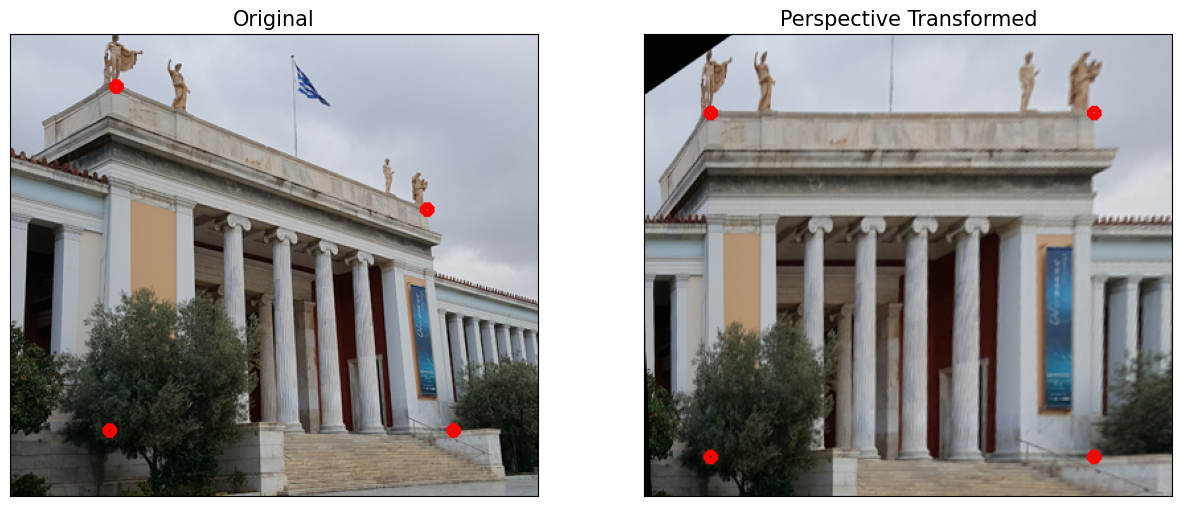

In [71]:
image = cv2.imread("./images/chap08/perspective.jpg", cv2.IMREAD_COLOR)
image_size = image.shape[-2::-1] # (width, height) 형태 크기

pts1 = np.array([
    (80, 40),
    (315, 133),
    (75, 300),
    (335, 300)
], dtype="float32") # 원본 영상의 좌표 4개

pts2 = np.array([
    (50, 60),
    (340, 60),
    (50, 320),
    (340, 320)
], dtype="float32") # 변환된 영상의 좌표 4개

perspective_mat = cv2.getPerspectiveTransform(pts1, pts2)
perspective_transformed = cv2.warpPerspective(image, perspective_mat, image_size, cv2.INTER_LINEAR)

checked_image = image.copy()
checked_perspective_transformed = perspective_transformed.copy()
for i in range(4):
    x, y = list(map(int, pts1[i]))
    cv2.circle(checked_image, (x, y), 3, (0, 0, 255), 3, -1) # 원본 영상에 네 점 표시

    x_prime, y_prime = list(map(int, pts2[i]))
    cv2.circle(checked_perspective_transformed, (x_prime, y_prime), 3, (0, 0, 255), 3, -1) # 변환된 영상에 네 점 표시

show_images({"Original": checked_image, "Perspective Transformed": checked_perspective_transformed}, 15)